In [10]:
import pandas as pd
import numpy as np
import os
import sys
import polars as pl
import json
from joblib import Parallel, delayed
import deepchem
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, GroupShuffleSplit, ShuffleSplit, StratifiedKFold
import gc
import random
from functools import partial
import catboost
from catboost import FeaturesData, Pool, CatBoost, CatBoostClassifier, CatBoostRegressor, CatBoostRanker
import time
import math
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt

from functools import partial
import mapply

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(20)
cfg.set_tbl_cols(50)

polars.config.Config

In [5]:
df = pl.scan_csv('/home/dangnh36/datasets/.comp/leash_belka/processed/train_v2.csv').select(
        pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
        (pl.col('BRD4') * 4 + pl.col('HSA') * 2 + pl.col('sEH')).alias('label')
    ).collect()
df

BRD4,HSA,sEH,label
u8,u8,u8,i64
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0


<Axes: >

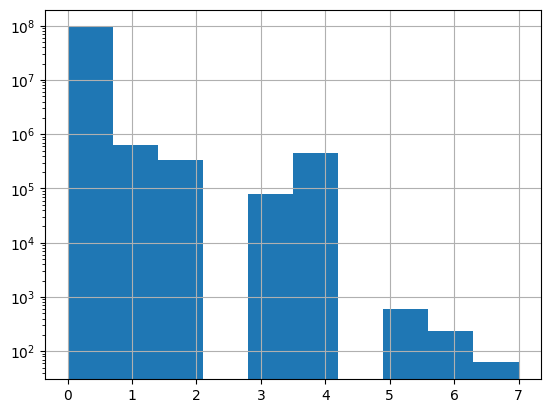

In [6]:
df['label'].to_pandas().hist(log = True)

FOLD 0


<Axes: >

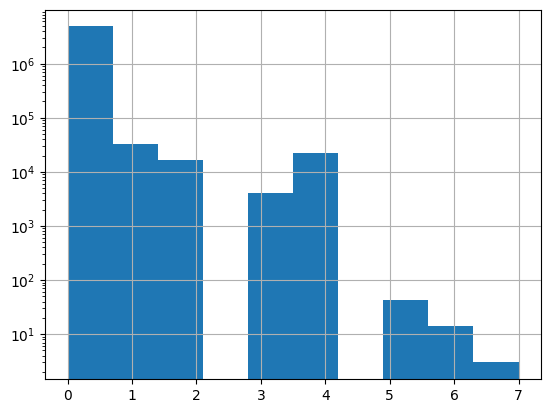

BRD4,HSA,sEH
f64,f64,f64
0.004619,0.004146,0.007353


FOLD 1


<Axes: >

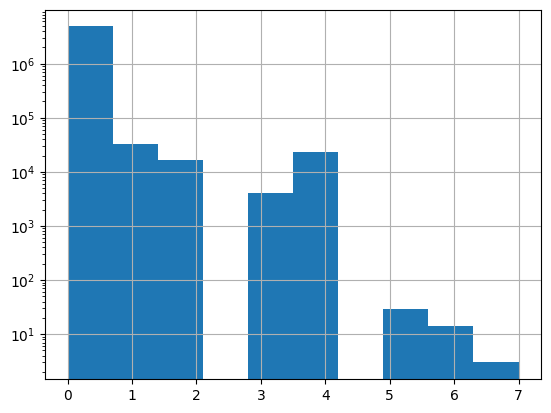

BRD4,HSA,sEH
f64,f64,f64
0.004674,0.004148,0.007434


FOLD 2


<Axes: >

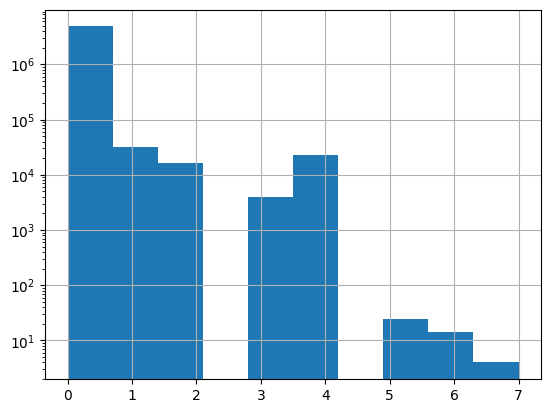

BRD4,HSA,sEH
f64,f64,f64
0.004649,0.004171,0.00739


FOLD 3


<Axes: >

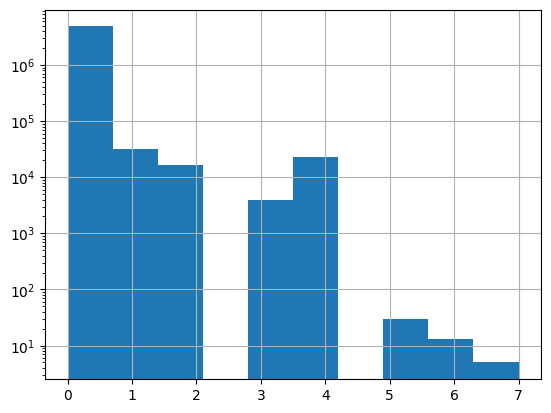

BRD4,HSA,sEH
f64,f64,f64
0.004619,0.004227,0.007392


FOLD 4


<Axes: >

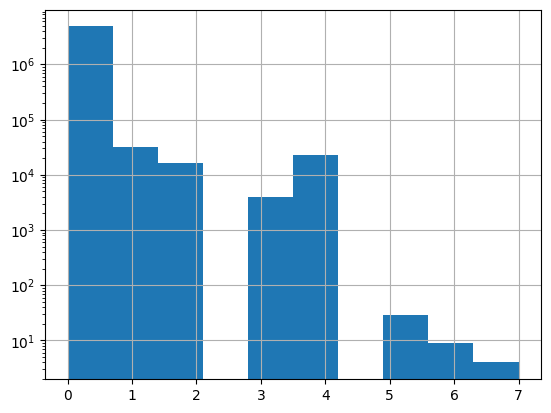

BRD4,HSA,sEH
f64,f64,f64
0.004603,0.004156,0.007358


FOLD 5


<Axes: >

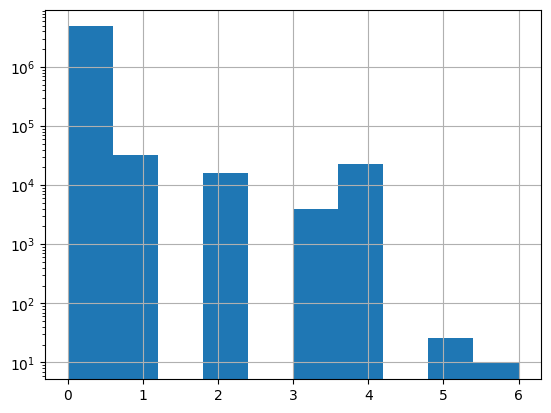

BRD4,HSA,sEH
f64,f64,f64
0.004667,0.00413,0.007361


FOLD 6


<Axes: >

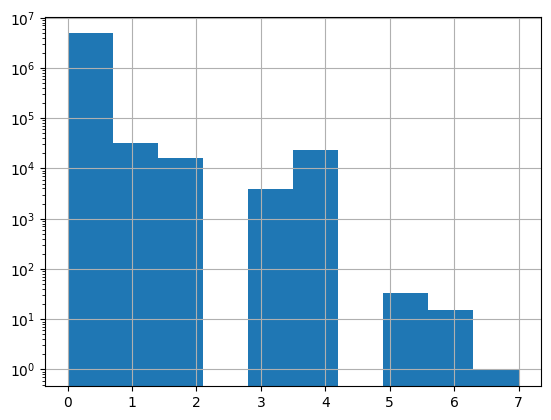

BRD4,HSA,sEH
f64,f64,f64
0.004662,0.004127,0.007373


FOLD 7


<Axes: >

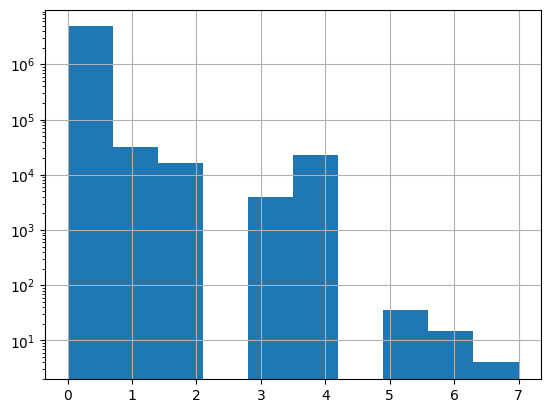

BRD4,HSA,sEH
f64,f64,f64
0.00463,0.004125,0.007361


FOLD 8


<Axes: >

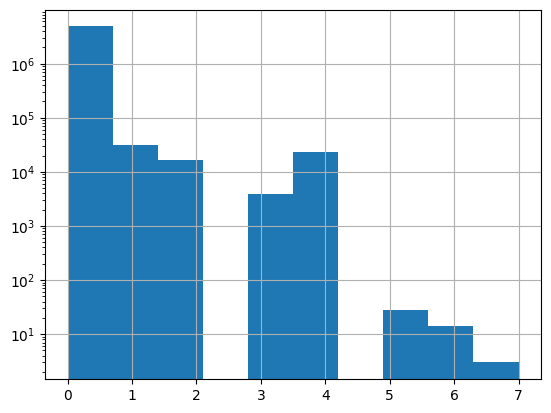

BRD4,HSA,sEH
f64,f64,f64
0.004639,0.004169,0.007304


FOLD 9


<Axes: >

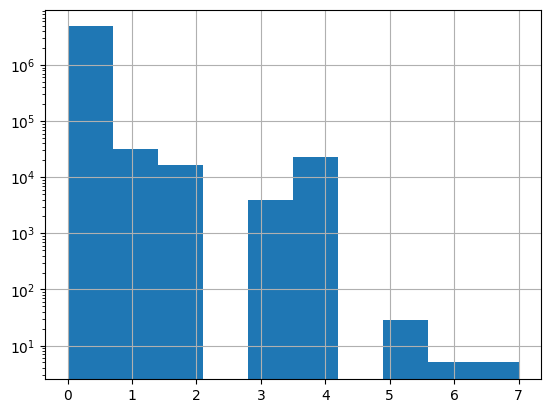

BRD4,HSA,sEH
f64,f64,f64
0.004646,0.004125,0.007313


FOLD 10


<Axes: >

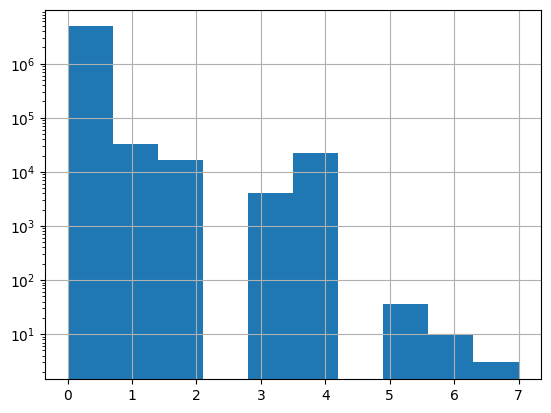

BRD4,HSA,sEH
f64,f64,f64
0.00462,0.004169,0.007324


FOLD 11


<Axes: >

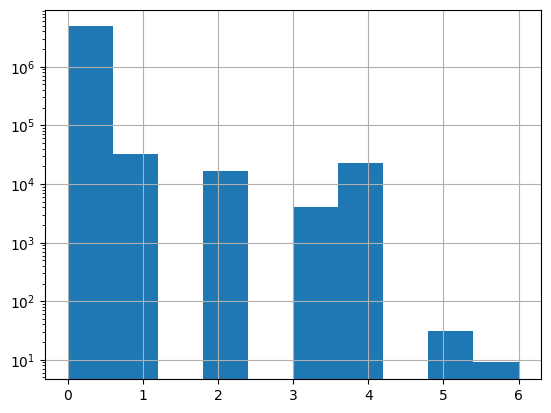

BRD4,HSA,sEH
f64,f64,f64
0.004659,0.004184,0.00742


FOLD 12


<Axes: >

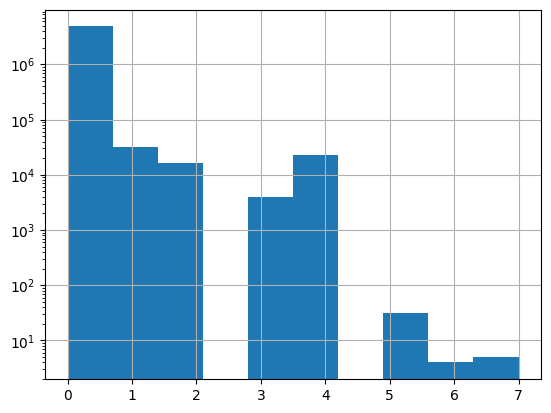

BRD4,HSA,sEH
f64,f64,f64
0.004655,0.004149,0.007338


FOLD 13


<Axes: >

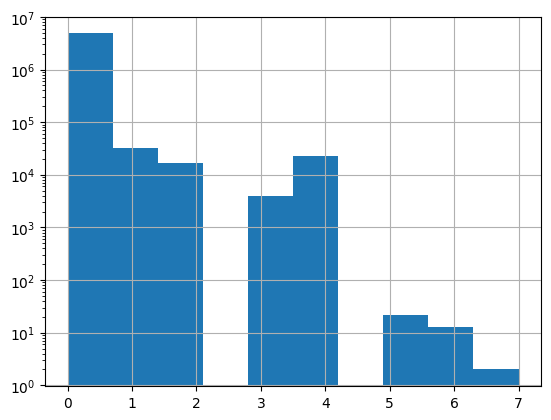

BRD4,HSA,sEH
f64,f64,f64
0.00464,0.004148,0.007319


FOLD 14


<Axes: >

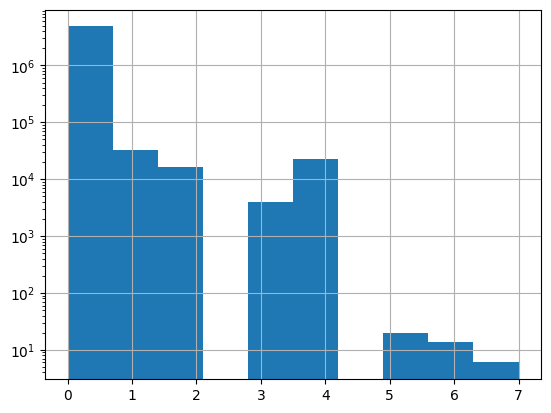

BRD4,HSA,sEH
f64,f64,f64
0.004642,0.004117,0.007344


FOLD 15


<Axes: >

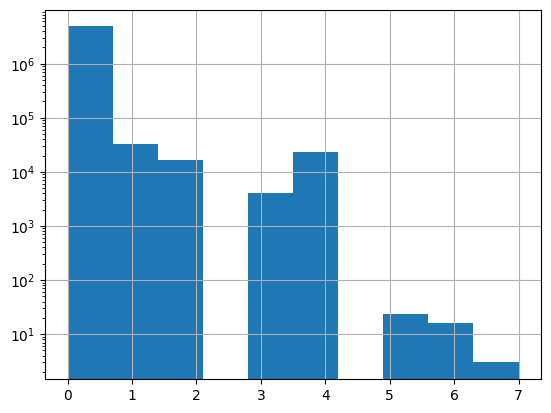

BRD4,HSA,sEH
f64,f64,f64
0.004703,0.004149,0.007319


FOLD 16


<Axes: >

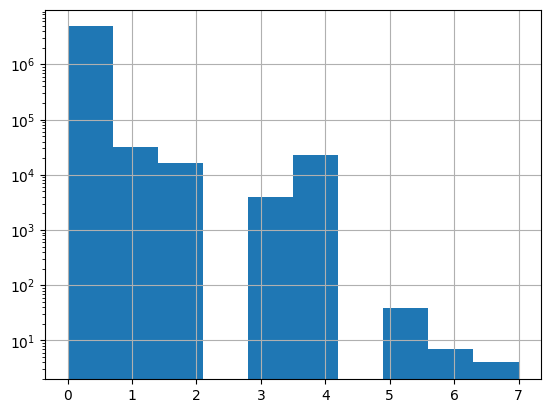

BRD4,HSA,sEH
f64,f64,f64
0.004616,0.00413,0.007379


FOLD 17


<Axes: >

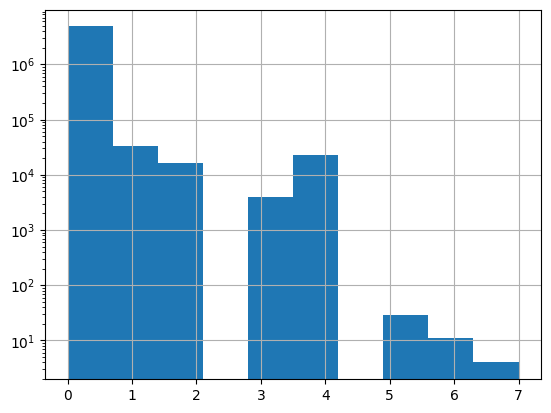

BRD4,HSA,sEH
f64,f64,f64
0.004616,0.00418,0.00742


FOLD 18


<Axes: >

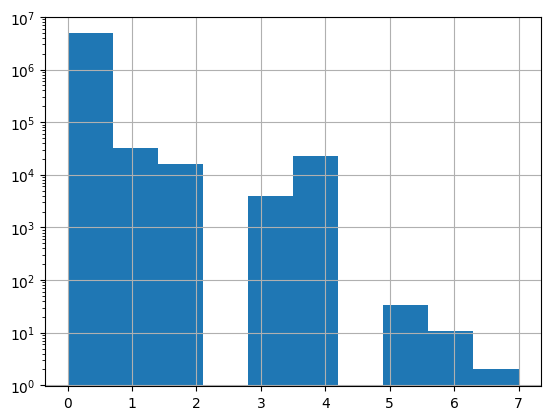

BRD4,HSA,sEH
f64,f64,f64
0.004645,0.004099,0.00739


FOLD 19


<Axes: >

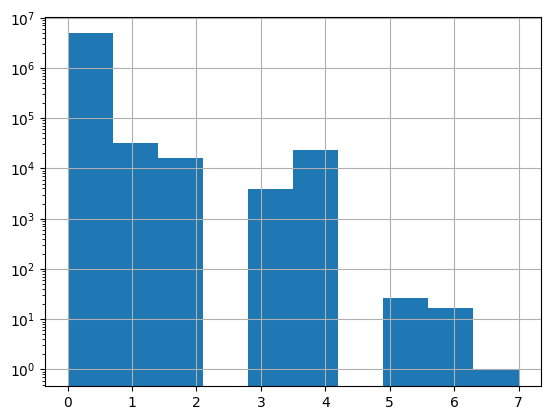

BRD4,HSA,sEH
f64,f64,f64
0.00466,0.004149,0.00735


In [32]:
N_FOLDS = 20
RANDOM_STATE = 42

# CV_NAME = f'skf{N_FOLDS}'
# splitter = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

CV_NAME = f'kf{N_FOLDS}'
splitter = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)


fold_meta = {}
for fold_idx, (train_idxs, val_idxs) in enumerate(splitter.split(list(range(len(df))), df['label'])):
    print('FOLD', fold_idx)
    fold_meta[fold_idx] = val_idxs.tolist()
    val_df = df[val_idxs]
    display(val_df.to_pandas()['label'].hist(log = True))
    plt.show()
    display(val_df.select(pl.col('BRD4', 'HSA', 'sEH').mean()))

In [33]:
set(fold_meta[0]).intersection(set(fold_meta[2]))

set()

In [34]:
for i in range(N_FOLDS): print(len(fold_meta[i]))

4920781
4920781
4920781
4920781
4920781
4920781
4920781
4920781
4920781
4920781
4920780
4920780
4920780
4920780
4920780
4920780
4920780
4920780
4920780
4920780


In [35]:
SAVE_PATH = f'/home/dangnh36/datasets/.comp/leash_belka/processed/cv/{CV_NAME}/val.json'
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

with open(SAVE_PATH, 'w') as f:
    json.dump(fold_meta, f)

In [36]:
cv_df = df.with_row_index('index').with_columns(pl.lit(-1).alias('fold_idx'))
cv_df

index,BRD4,HSA,sEH,label,fold_idx
u32,u8,u8,u8,i64,i32
0,0,0,0,0,-1
1,0,0,0,0,-1
2,0,0,0,0,-1
3,0,0,0,0,-1
4,0,0,0,0,-1
5,0,0,0,0,-1
6,0,0,0,0,-1
7,0,0,0,0,-1
8,0,0,0,0,-1


In [37]:
for fold_idx, val_idxs in fold_meta.items():
    cv_df[val_idxs, 'fold_idx'] = fold_idx
cv_df

index,BRD4,HSA,sEH,label,fold_idx
u32,u8,u8,u8,i64,i32
0,0,0,0,0,10
1,0,0,0,0,15
2,0,0,0,0,1
3,0,0,0,0,10
4,0,0,0,0,0
5,0,0,0,0,7
6,0,0,0,0,8
7,0,0,0,0,16
8,0,0,0,0,10


In [38]:
cv_df.select(pl.col('fold_idx').n_unique())

fold_idx
u32
20


In [39]:
cv_df.select('index', 'fold_idx').write_csv(f'/home/dangnh36/datasets/.comp/leash_belka/processed/cv/{CV_NAME}/cv.csv')